# SHAP visualisation of Digits

The following example is based in the SHAP documentation[^1]



The official documentation lacks explanation and examples of multi-class classification interpretations. Most of the time they show one-vs-rest visualisations of each class of interest. For example in the Iris example[^2]



## Other discussions about SHAP for multi-class

- GitHub shap/shap [#issue 367: Understanding SHAP for multi-classification problem](https://github.com/shap/shap/issues/367)
- Shap documentation [Emotion Classification Multiclass Example](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html#)
- YouTube [SHAP for Binary and Multiclass Target Variables | Code and Explanations for Classification Problems](https://www.youtube.com/watch?v=2xlgOu22YgE)
    - Binary: Log-odds
    - Multiclass: Softmax
- S. A. Ludwig, "[Explainability Using SHAP for Epileptic Seizure Recognition](https://ieeexplore.ieee.org/abstract/document/10021103?casa_token=UXzKfFKvJysAAAAA:tzFFLhyeKCSbBlEStBr6QtCbC1rmIiP-HPTXOsrq5MEqWWvQT1yz2dUsZGN2fqJR9fXLAPwz)" 2022 IEEE International Conference on Big Data (Big Data), Osaka, Japan, 2022, pp. 5305-5311, doi: 10.1109/BigData55660.2022.10021103.
- Lev V. Utkin, Andrei V. Konstantinov, Kirill A. Vishniakov, "[An Imprecise SHAP as a Tool for Explaining the Class Probability Distributions under Limited Training Data](https://arxiv.org/abs/2106.09111)", arXiv, 16 Jun 2021, https://doi.org/10.48550/arXiv.2106.09111
- Alec Lamens, andJürgen Bajorath, "[Explaining Multiclass Compound Activity Predictions Using Counterfactuals and Shapley Values](https://www.mdpi.com/1420-3049/28/14/5601)", Molecules 2023, 28(14), 5601; https://doi.org/10.3390/molecules28145601
- Mantas Bacevicius, and Agne Paulauskaite-Taraseviciene, "[Machine Learning Algorithms for Raw and Unbalanced Intrusion Detection Data in a Multi-Class Classification Problem](https://www.mdpi.com/2076-3417/13/12/7328)", Appl. Sci. 2023, 13(12), 7328; https://doi.org/10.3390/app13127328
- Sanghun Lee, Sangyeop Kim, Jaehoon Kim, Doyun Kim, Dohyun Lee, Gwangmuk Im, Hyeonseop Yuk, Tae-Young Heo, "[Multiclass Classification by Various Machine Learning Algorithms and Interpretation of the Risk Factors of Pedestrian Accidents Using Explainable AI](https://www.hindawi.com/journals/mpe/2023/1956865/)", Mathematical Problems in Engineering, vol. 2023, Article ID 1956865, 15 pages, 2023. https://doi.org/10.1155/2023/1956865
- T. P. De Faria, M. Z. Do Nascimento and L. G. A. Martins, "[Understanding the multiclass classification of lymphomas from simple descriptors,](https://ieeexplore.ieee.org/abstract/document/9798963?casa_token=YaL1alPhWuYAAAAA:YaEnZP7znBNEE3CGIFcbhhC5Cc9KPjZ30akRsgTab4RkJQxGaLwuE3-ySH4MfznRru4ISMn9)" 2021 International Conference on Computational Science and Computational Intelligence (CSCI), Las Vegas, NV, USA, 2021, pp. 1202-1208, doi: 10.1109/CSCI54926.2021.00250.
- S. Ahmed, S. N. Nobel and O. Ullah, "[An Effective Deep CNN Model for Multiclass Brain Tumor Detection Using MRI Images and SHAP Explainability](https://ieeexplore.ieee.org/abstract/document/10101503?casa_token=c_NGI27s0b8AAAAA:TPN82fn--foXGd6zZ3eugCh29JGo9xG3iS4K0Cz3rUjp10G37eN51a6_oAqOTnUhIws827x6)," 2023 International Conference on Electrical, Computer and Communication Engineering (ECCE), Chittagong, Bangladesh, 2023, pp. 1-6, doi: 10.1109/ECCE57851.2023.10101503.
- 


[^1]: https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html
[^2]: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
N_class = 10   #Number of class, the dimension of the simplex is therefore N_class-1

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X = X.reshape(-1, 8, 8, 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [3]:
#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train.reshape(-1, 64), Y_train)

SVC(probability=True)

## Problem showing more than 1 sample

The original example is able to show multiple examples by indicating in the final explainer call

```
 X_test[1:3]
```

However, I get an error in such case, and I had to select only one output as a list

```
X_test[0:1]
```

In [9]:
import shap

# python function to get model output; replace this function with your own model function.
def f(x):
    return svc_linear.predict_proba(x.reshape(-1, 64))

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=range(N_class))

# here we explain one image using 500 evaluations and showing only the top 4 class predictions
shap_values = explainer(
    X_test[:3], max_evals=100, batch_size=50#, outputs=shap.Explanation.argsort.flip[:4]
)

In [14]:
shap_values.transpose(4, 0)

AttributeError: 'Explanation' object has no attribute 'transpose'

IndexError: index 1 is out of bounds for axis 0 with size 1

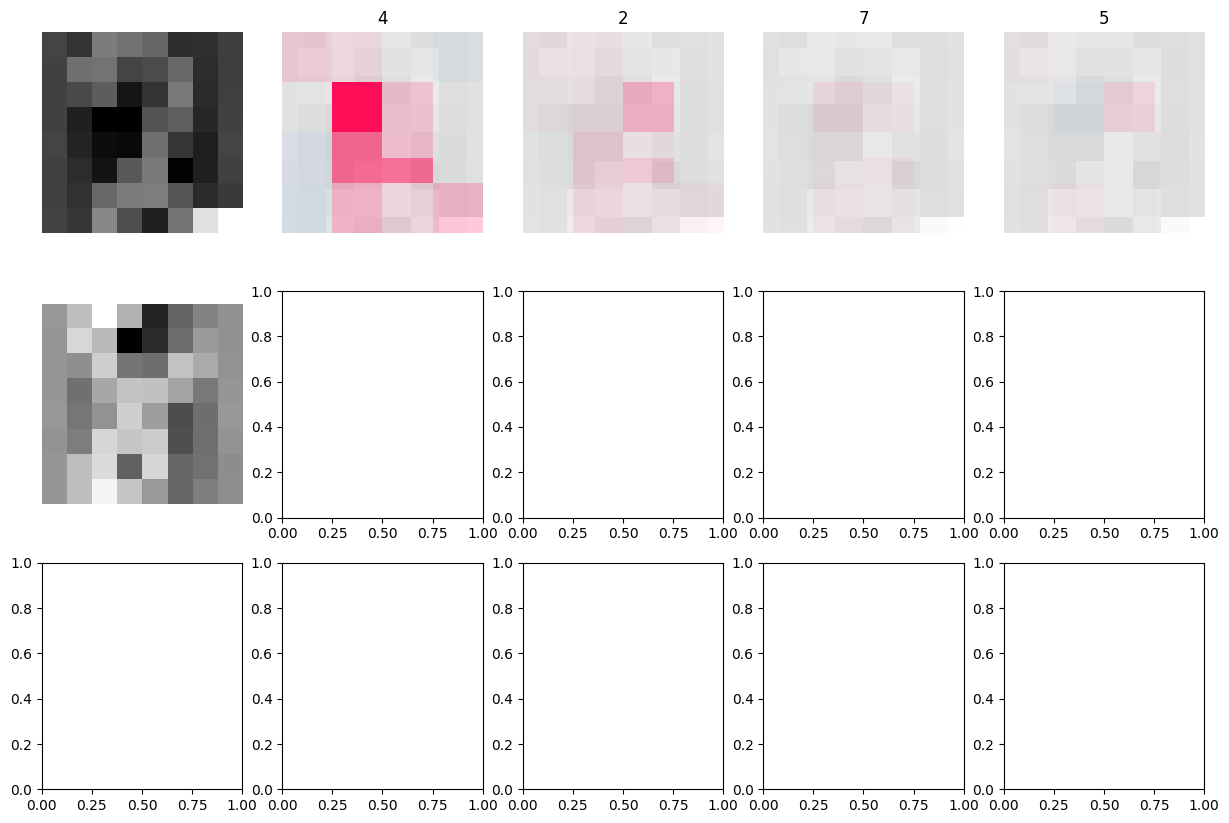

In [7]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot(shap_values)

# Direct copy of SHAP documentation

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html

In [15]:
import json

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import shap

ModuleNotFoundError: No module named 'tensorflow'